In [44]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import delve
import os
import numpy as np

In [45]:
path = "./multipath_experiments"
if not os.path.exists(path):
    os.mkdir(path)

In [46]:
from matplotlib import rc

params = {
#           'text.latex.preamble': [r'\usepackage{gensymb}'],
          'axes.labelsize': 18, # fontsize for x and y labels (was 10)
          'axes.titlesize': 18,
          'font.size': 16, # was 10
          'legend.fontsize': 16, # was 10
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'font.family': 'serif',
          'figure.dpi': 300
}
#mpl.rcParams['figure.dpi'] = 900
import matplotlib
matplotlib.rcParams.update(params)
#rc('text', usetex=True)

In [47]:
def decomposed_mpnet_model_name(model_name):
    result = model_name.split("_")[1:]
    length = len(result) // 2
    print(length)
    r = {int(result[length+i]): int(result[i])  for i in range(length)}
    return r

In [48]:
decomposed_mpnet_model_name("MPNet18_2_2_3_7")

2


{3: 2, 7: 2}

In [49]:
model = "MPNet18_2_7"
batch_size = 64
epochs = 30
run_id = "DIS"
resolution = 32
dataset = "Cifar10"

sat_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/{model}-{dataset}-r{resolution}-bs{batch_size}-e{epochs}.csv'
probe_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/4x4_probe_performances.csv'
receptive_field_file = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"


In [50]:
receptive_field_color = {
    "pathway0" : "blue",
    "pathway1" : "steelblue"
}

probes_color = {
    "pathway0" : "maroon",
    "pathway1" : "lightsalmon"    
}

sats_color = {
    "pathway0" : "darkgreen",
    "pathway1" : "lightgreen"    
}

legend_names = {
    "pathway0": "$r_{min}$",
    "pathway1": "$r_{max}$"
}


names = {
    "pathway0": "$b_{min}$",
    "pathway1": "$b_{max}$"
}

rf_name = {
    "pathway0": "$r_{l,min}$",
    "pathway1": "$r_{l,max}$"
}

probe_name = {
    "pathway0": "$p_{l,min}$",
    "pathway1": "$p_{l,max}$" 
}

sat_name = {
    "pathway0": "$s_{l,min}$",
    "pathway1": "$s_{l,max}$" 
}

alpha = 0.7

In [51]:
from pprint import pprint 
from collections import defaultdict

def extract_layer_stat(file, primary_metric="test_accuracy", stat='saturation'):
    """
    Extracts a specific statistic for a single epoch from a result dataframe as produced by the CSV-writer
    :param df: the dataframe as produced by the csv-writer
    :param epoch: the epoch to filter by
    :param primary_metric: the primary metric for logged for performance evaluation, may be left empty
    :param stat: the statistic to look for, must be a substring matching all columns belonging to stat statistic like "saturation"
    :return: a dataframe with a single row, corresponding to the epoch containing only the columns that contain the substring
    described in the stat-parameter in their name. Second return value is the primary metric value
    """
    df = pd.read_csv(file, sep=";")
    epoch = len(df)-1
    cols = list(df.columns)
    train_cols = [col for col in cols if
                  'train' in col and not 'accuracy' in col and stat in col and not "linear" in col]
    if not np.any(epoch == df.index.values):
        raise ValueError(f'Epoch {epoch} could not be recoreded, dataframe has only the following indices: {df.index.values}')
    epoch_df = df[df.index.values == epoch]
    pm = None if primary_metric is None else epoch_df[primary_metric].values[0]
    #print(pm)
    epoch_df = epoch_df[train_cols]
    result = epoch_df.to_dict()
    finalized_result = {key.split(f"train-{stat}_")[-1]: value[epoch] for key, value in result.items()}
    return finalized_result, pm


def extract_probe_performances(probe_file, saturation_values):
    df = pd.read_csv(probe_file, sep=";")
    #display(df)
    df["name"] = df["name"].apply(lambda x: x.split("train-")[-1])
    probe_dict = {name: df[df["name"] == name]["eval_acc"].values[0] for name in saturation_values.keys()}
    #pprint(probe_dict)
    return probe_dict

def extract_receptive_field(receptive_field_file):
    return pd.read_csv(receptive_field_file, sep=";")["receptive_field"].values

def find_border_layer(receptive_fields_in_layer, input_res):
    #print(receptive_fields_in_layer)
    k = receptive_fields_in_layer > input_res
    x = np.argmax(k)
    return len(k)-1 if all(k == False) else x + 1

def plot_sats_and_probes(ax, indices, sat_vals, prb_vals, sat_color="green", probe_color="red", linestyle_sat="-", linestyle_probes="-", sat_label="Saturation", probe_label="Probe Accuracy"):
    print(indices)
    ax.plot(indices, prb_vals, label=probe_label, color=probe_color, linestyle=linestyle_probes, alpha=alpha)
    ax.scatter(indices, prb_vals, color=probe_color, linestyle=linestyle_probes, alpha=alpha)    
    
    ax.plot(indices, sat_vals, label=sat_label, color=sat_color, linestyle=linestyle_sat, alpha=alpha)
    ax.scatter(indices, sat_vals, color=sat_color, linestyle=linestyle_sat, alpha=alpha)    
    
    
def plot_saturation(fig, ax1, ax2, sats, probes, recep, input_res, primary_metric):
    ticks = list(sats.keys())
    sat_vals = list(sats.values())
    prb_vals = list(probes.values())
    indices = list(range(len(recep)))
    ax2_indices = list(range(len(prb_vals)))

    
    ax1.plot(indices, recep, label='Receptive Field', color='blue')
    ax1.scatter(indices, recep, color='blue')
    plot_sats_and_probes(ax2, ax2_indices, sat_vals, prb_vals)
    border = find_border_layer(recep, input_res)
    ax2.vlines(ax_indices[border], border, 0, 1)
    plt.text(ax_indices[border]+0.1, 0,f'Border {pathway}',rotation=90)
    
    ax2.plot(ax2_indices, [pm/100 for idx in ax2_indices], color='black', linestyle='--', label=f'model test acc.: {round(pm, 2)}%')

    plt.grid()
    
def check_groups(layer_name, pathways):
    return [pathway in layer_name for pathway in pathways]


    
#fig, ax1 = plt.subplots(figsize=(8, 2.5))   
#ax2 = ax1.twinx() 

#saturation_values, pm = extract_layer_stat(sat_file, "test_accuracy")
#probes = extract_probe_performances(probe_file, saturation_values)
#recep = extract_receptive_field(receptive_field_file)
#plot_saturation(fig, ax1, ax2, saturation_values, probes, recep, 32, pm)
#pprint(probes)

In [52]:
pd.read_csv(receptive_field_file, sep=";")["receptive_field"].values

array([  3.,   9.,  15.,  21.,  27.,  39.,  51.,  63.,  75.,  99., 123.,
       147., 171., 219., 267., 315., 363.])

In [53]:
def add_receptive_field(result, receptive_field_file, pathway_name):
    recep = extract_receptive_field(receptive_field_file)
    pprint(receptive_field_file)
    pprint(recep)
    for i, (layer_name, (probe, sat)) in enumerate(result[pathway_name].items()):
        result[pathway_name][layer_name] = (probe, sat, recep[i])
    return result
        

def group_by_plot_multipath(probes, saturation_values, receptive_field_file_template, pathway_groups, model):
    result = {pathway: dict() for pathway in pathway_groups}
    for (layer_name, probe), (_, sats) in zip(probes.items(), saturation_values.items()):
        if not any(check_groups(layer_name, pathway_groups)):
            for path in pathway_groups:
                result[path][layer_name] = probe, sats
        else:
            idx = check_groups(layer_name, pathway_groups).index(True)
            result[pathway_groups[idx]][layer_name] = probe, sats
    model_files_metadata = decomposed_mpnet_model_name(model)
    
    new_model_names = [f"{model.split('_')[0]}_{layers}_{kernel}" for kernel, layers in model_files_metadata.items()]
    new_receptive_field_files = [receptive_field_file_template.replace(model, new_model) for new_model in new_model_names]
    for new_file, pathway in zip(new_receptive_field_files, pathway_groups):
        add_receptive_field(result, new_file, pathway)
    pprint(result)
    return result


def reformat_multipath(groups):
    result = {}
    for pathway in groups.keys():
        #pprint(groups[pathway])
        layers, sats, probes, receps = [], [], [], []
        for layer_name, (probe, sat, recep) in groups[pathway].items():
            layers.append(layer_name), sats.append(sat), probes.append(probe), receps.append(recep)
        result[pathway] = (layers, probes, sats, receps)
    return result


def _plot_saturation(fig, ax1, ax2, ticks, sat_vals, prb_vals, recep, input_res, primary_metric, indices, linestyle, pathway, plot_pm):
    #indices = list(range(len(recep)))
    ax2_indices = indices

    
    ax1.plot(indices, recep, label=rf_name[pathway], color=receptive_field_color[pathway], linestyle=linestyle, alpha=alpha)
    ax1.scatter(indices, recep, color=receptive_field_color[pathway], alpha=alpha)
    plot_sats_and_probes(ax2, ax2_indices, sat_vals, prb_vals, linestyle_sat=linestyle, linestyle_probes=linestyle, sat_color=sats_color[pathway], probe_color=probes_color[pathway], sat_label=sat_name[pathway], probe_label=probe_name[pathway])
    border = find_border_layer(recep, input_res)
    print("Receptive Field", recep)
    ax2.vlines(ax2_indices[border], 0, 1)
    plt.text(ax2_indices[border]+0.1, 0,f'{names[pathway]}',rotation=90)
    if plot_pm:
        ax2.plot(ax2_indices, [primary_metric/100 for idx in ax2_indices], color='black', linestyle='--', label=f'test acc.: {round(primary_metric, 2)}%')
    ax2.set_ylabel("Accuracy / Saturation")
    ax1.set_ylabel("Receptive Field Size")
    ax1.set_xticks([])
    ax1.set_xlabel("Layers")
    plt.grid()
    

def compute_indices(groups):
    lengths = {pathway: len(probes) for pathway, (_, _, probes, fields) in groups.items()}
    indices = {pathway: int(max(list(lengths.values())) / l) for pathway, l in lengths.items()}
    index = {}
    for pathway, l in lengths.items():
        index[pathway] = int(((max(list(lengths.values())))-1) / (l-1))
    return index
            
    
def plot_multipath(model, sat_file, probe_file, receptive_field_file, pathway_groups = ["pathway0", "pathway1"]):
    fig, ax1 = plt.subplots(figsize=(8, 2.5))   
    ax2 = ax1.twinx()
    saturation_values, pm = extract_layer_stat(sat_file, "test_accuracy")
    probes = extract_probe_performances(probe_file, saturation_values)
    pprint(probe_file)

    groups = group_by_plot_multipath(probes, saturation_values, receptive_field_file_template, pathway_groups, model)
    reformated_groups = reformat_multipath(groups)
    linestyles =["-", "-"] #["--", ":"]
    plot_pm = False
    for style, (pathway, (l_names, sats, probes, fields)) in zip(linestyles, reformated_groups.items()):
        indices = compute_indices(reformated_groups)
        print(indices)
        idx = [0] + list(range(1, len(probes)* indices[pathway], indices[pathway]))
        idx = idx if len(idx)%2 == 1 else idx[:-1]
        print("Results", idx)
        _plot_saturation(fig, ax1, ax2, l_names, probes, sats, np.asarray(fields), 32, pm, idx, linestyle=style, pathway=pathway, plot_pm=plot_pm)
        plot_pm = not plot_pm
    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels+labels2, handles+handles2), key=lambda t: t[0]))
    #ax.legend(handles, labels)

    fig.legend(handles, labels, bbox_to_anchor=(1.05, 1.4), framealpha=0.1, ncol=4)

    plt.grid()
    
    return reformated_groups

'./logs/MPNet18_2_2_3_7/Cifar10_32/DIS/4x4_probe_performances.csv'
2
'./logs/MPNet18_2_3/Cifar10_32/DIS/receptive_field_MPNet18_2_3_Cifar10_32.csv'
array([  3.,   5.,   7.,   9.,  11.,  15.,  19.,  23.,  27.,  35.,  43.,
        51.,  59.,  75.,  91., 107., 123.])
'./logs/MPNet18_2_7/Cifar10_32/DIS/receptive_field_MPNet18_2_7_Cifar10_32.csv'
array([  3.,   9.,  15.,  21.,  27.,  39.,  51.,  63.,  75.,  99., 123.,
       147., 171., 219., 267., 315., 363.])
{'pathway0': {'conv1': (0.382, 0.171875, 3.0),
              'stage1-0-pathway0-layers-0-0': (0.6024, 0.53125, 5.0),
              'stage1-0-pathway0-layers-1-0': (0.6643, 0.6875, 7.0),
              'stage1-1-pathway0-layers-0-0': (0.7088, 0.703125, 9.0),
              'stage1-1-pathway0-layers-1-0': (0.7332, 0.640625, 11.0),
              'stage2-0-pathway0-layers-0-0': (0.7895, 0.6875, 15.0),
              'stage2-0-pathway0-layers-1-0': (0.8142, 0.6640625, 19.0),
              'stage2-1-pathway0-layers-0-0': (0.8559, 0.65625, 23.

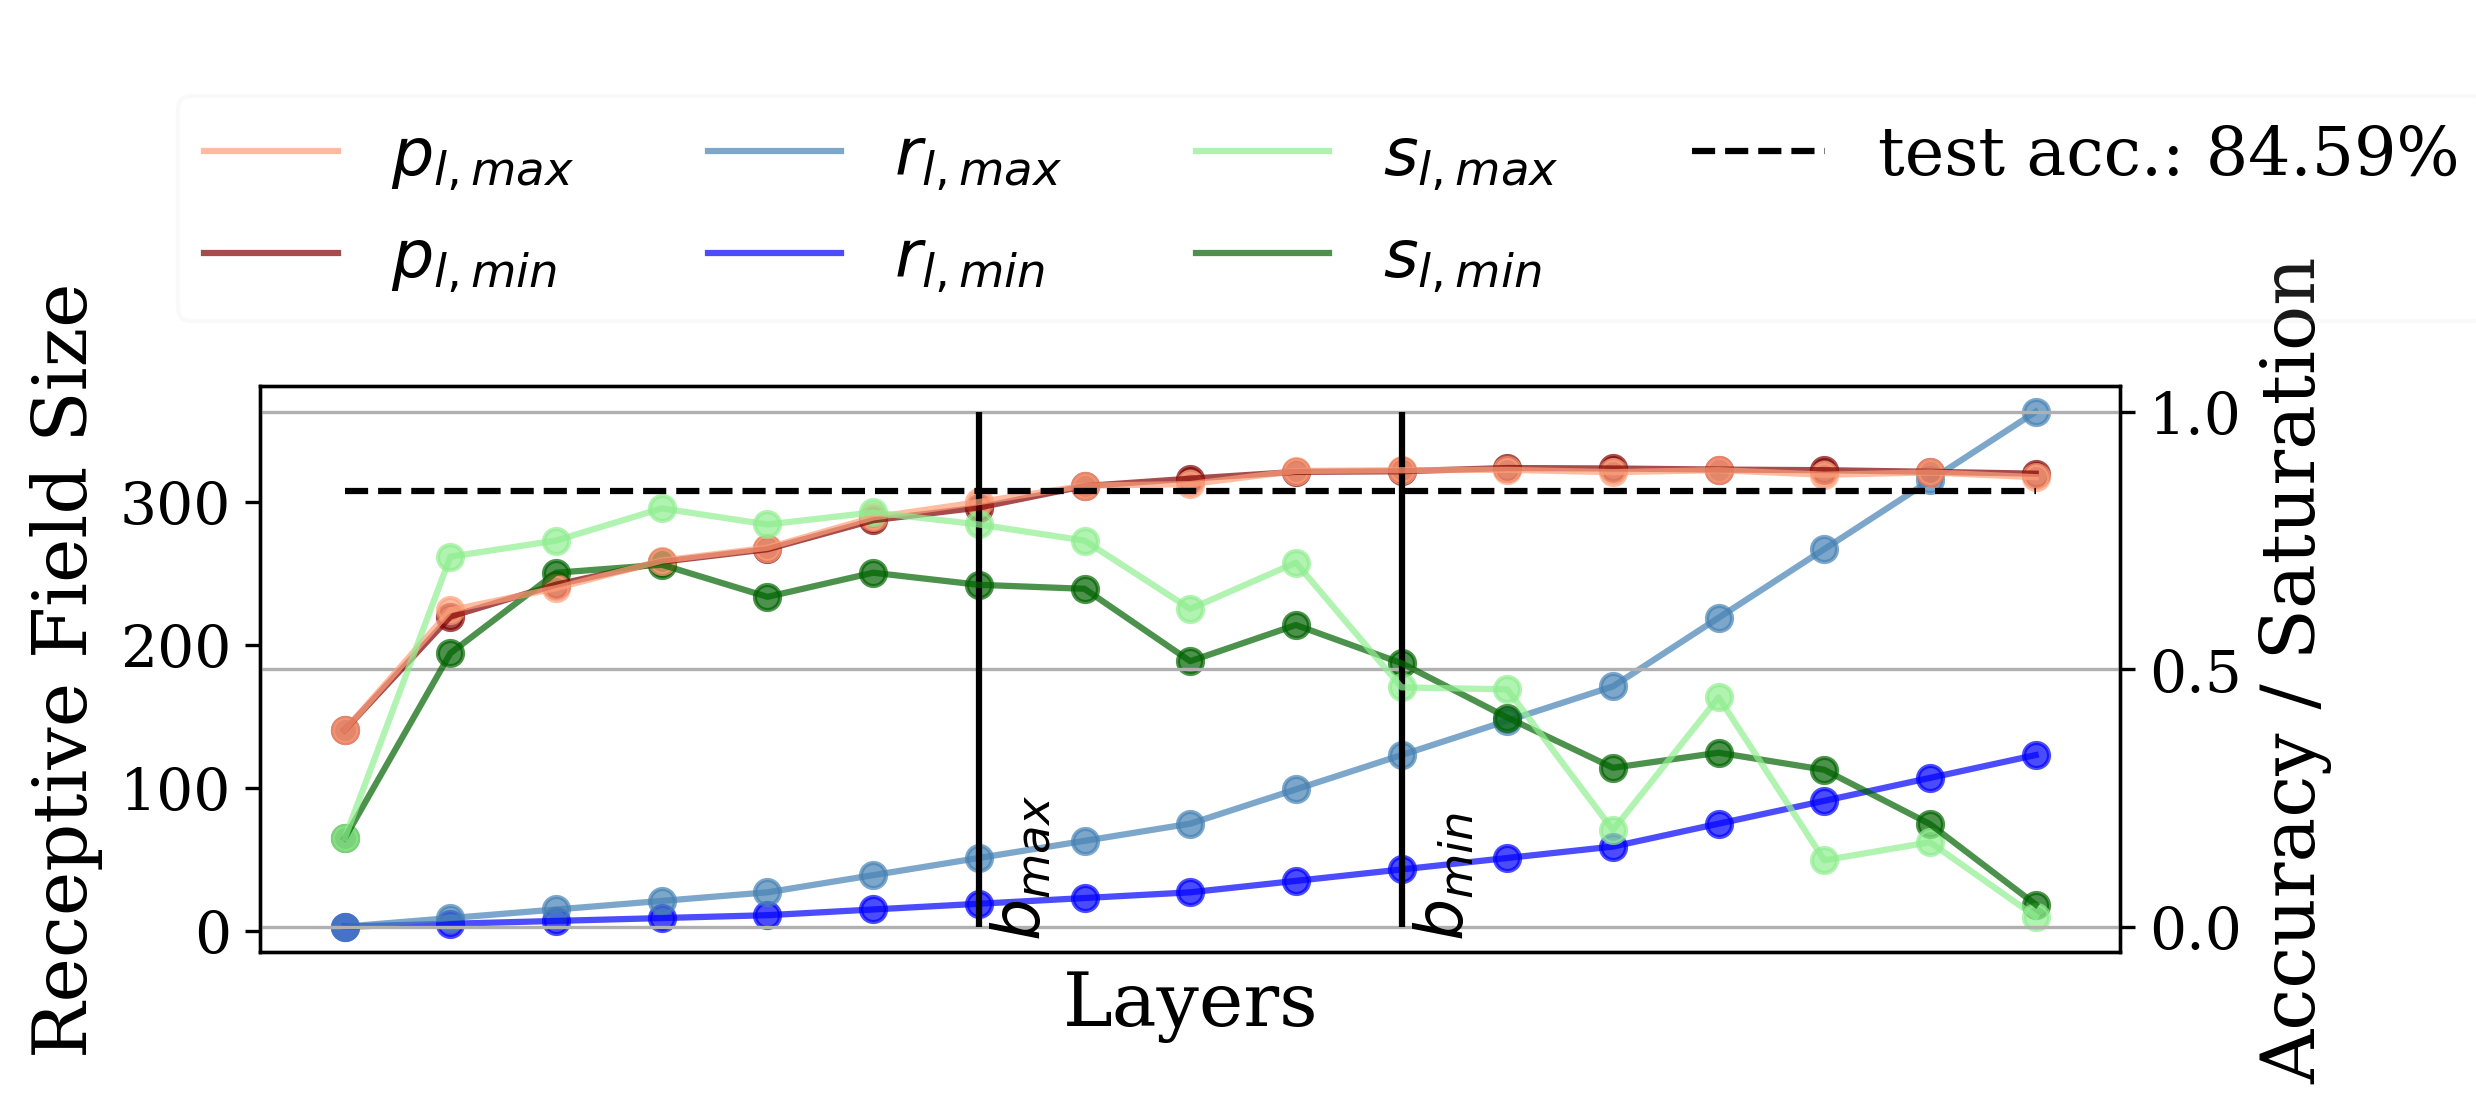

In [55]:
model = "MPNet18_2_2_3_7"
batch_size = 64
epochs = 30
run_id = "DIS"
resolution = 32
dataset = "Cifar10"

sat_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/{model}-{dataset}-r{resolution}-bs{batch_size}-e{epochs}.csv'
probe_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/4x4_probe_performances.csv'
receptive_field_file = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"
receptive_field_file_template = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"

#print(sat_file)
r = plot_multipath(model, sat_file, probe_file, "")
#pprint(r)
savepath = os.path.join(path,f'{model}_{dataset}_{resolution}.png')
print(model)
plt.savefig(savepath, bbox_inches='tight')

'./logs/MPNet18_2_2_1_7/Cifar10_32/DIS/4x4_probe_performances.csv'
2
'./logs/MPNet18_2_1/Cifar10_32/DIS/receptive_field_MPNet18_2_1_Cifar10_32.csv'
array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])
'./logs/MPNet18_2_7/Cifar10_32/DIS/receptive_field_MPNet18_2_7_Cifar10_32.csv'
array([  3.,   9.,  15.,  21.,  27.,  39.,  51.,  63.,  75.,  99., 123.,
       147., 171., 219., 267., 315., 363.])
{'pathway0': {'conv1': (0.3798, 0.15625, 3.0),
              'stage1-0-pathway0-layers-0-0': (0.6409, 0.265625, 3.0),
              'stage1-0-pathway0-layers-1-0': (0.6671, 0.359375, 3.0),
              'stage1-1-pathway0-layers-0-0': (0.7196, 0.515625, 3.0),
              'stage1-1-pathway0-layers-1-0': (0.7305, 0.46875, 3.0),
              'stage2-0-pathway0-layers-0-0': (0.7921, 0.375, 3.0),
              'stage2-0-pathway0-layers-1-0': (0.8036, 0.4375, 3.0),
              'stage2-1-pathway0-layers-0-0': (0.8479, 0.6015625, 3.0),
              'stage2-1-pathway0-layers-1

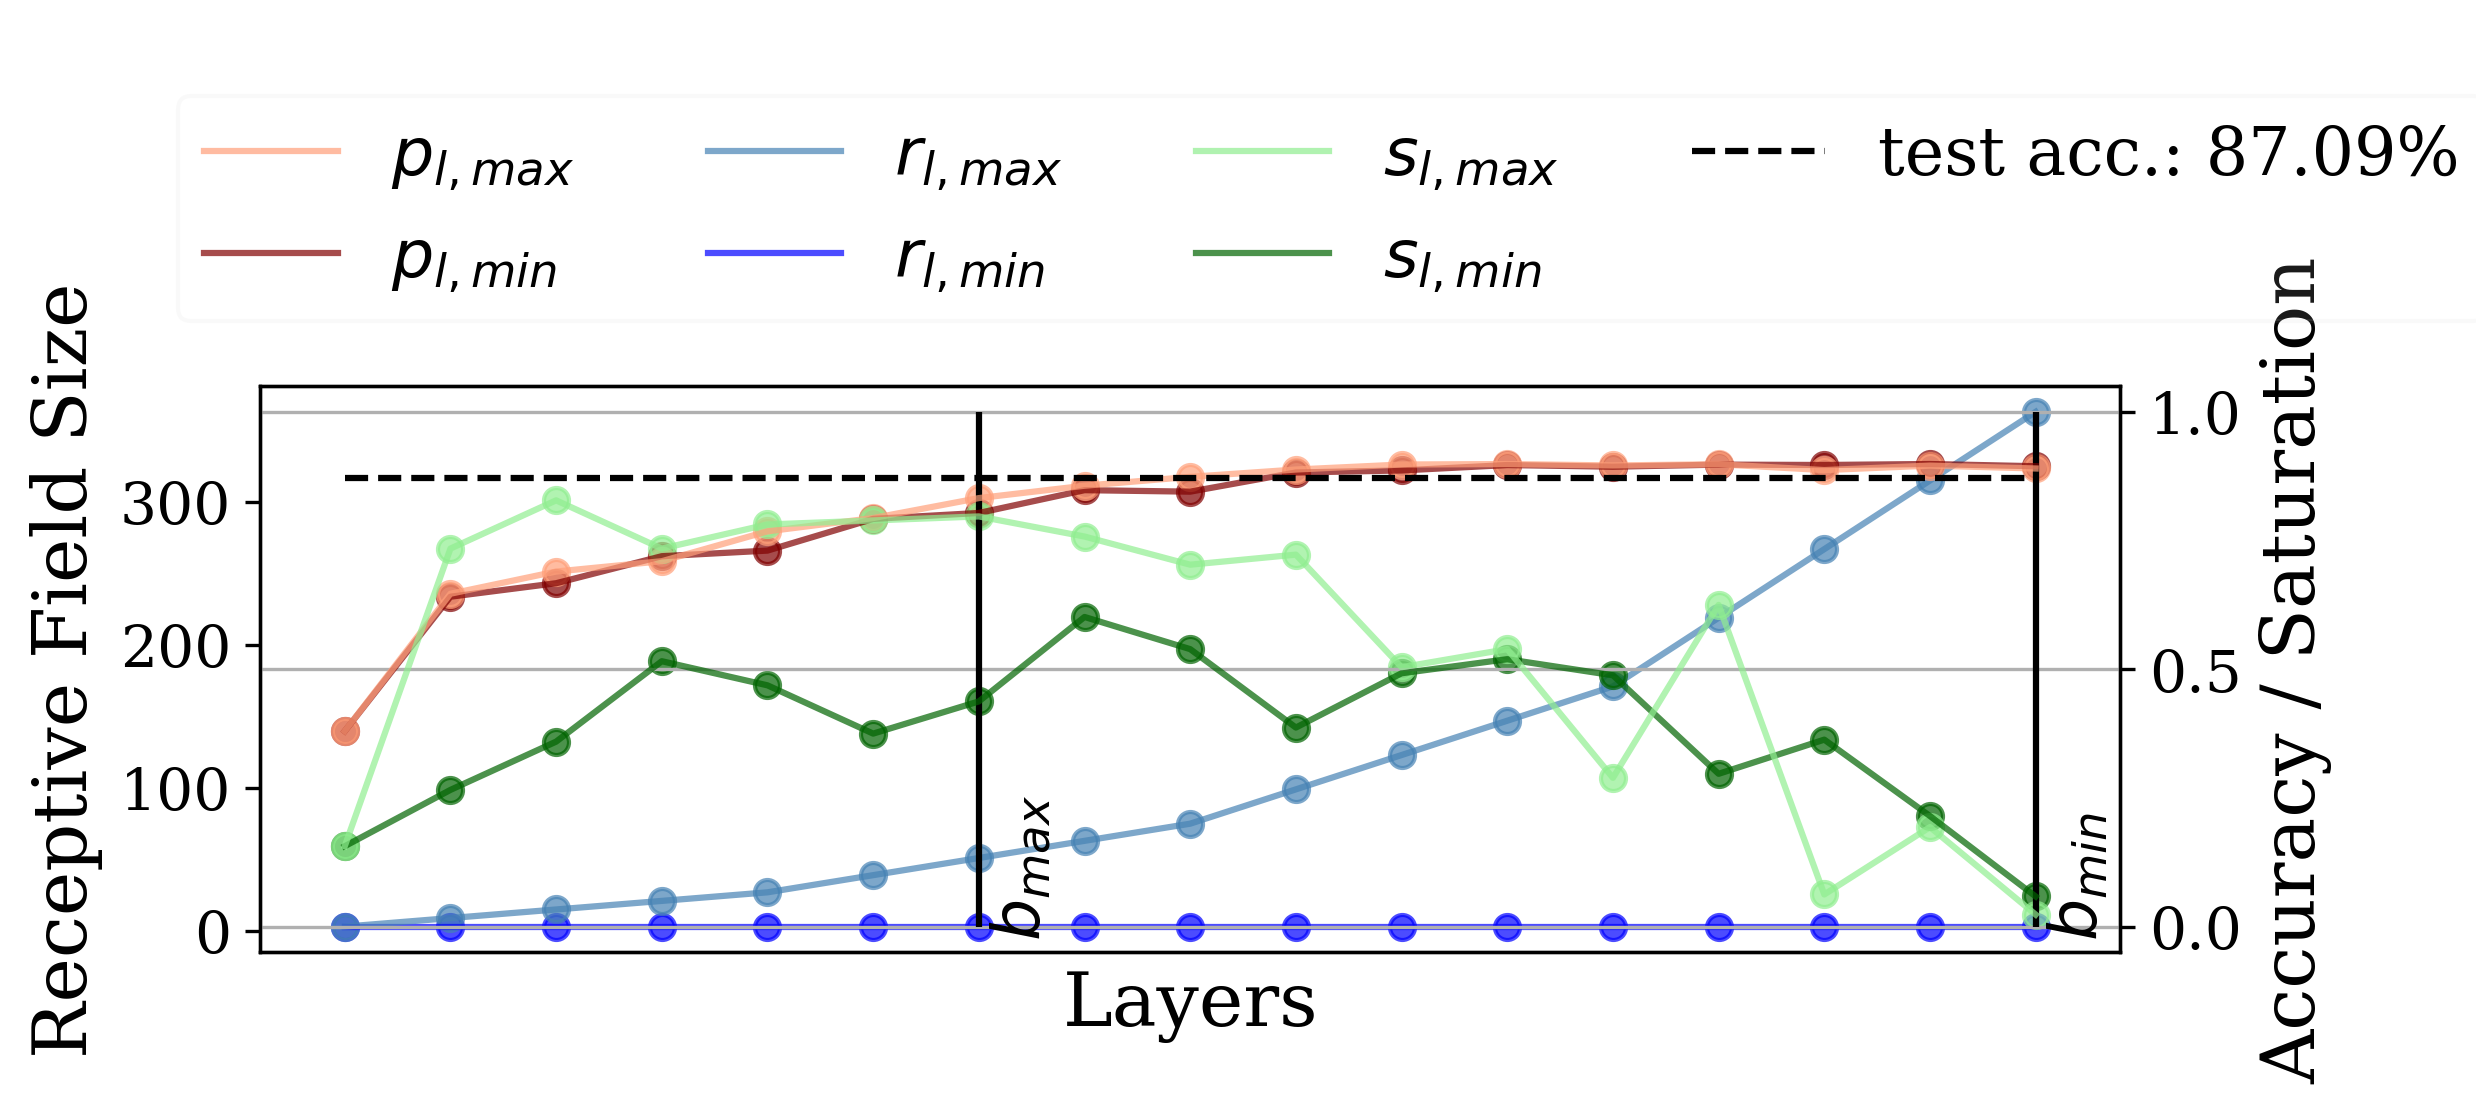

In [56]:
model = "MPNet18_2_2_1_7"
batch_size = 64
epochs = 30
run_id = "DIS"
resolution = 32
dataset = "Cifar10"

sat_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/{model}-{dataset}-r{resolution}-bs{batch_size}-e{epochs}.csv'
probe_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/4x4_probe_performances.csv'
receptive_field_file = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"
receptive_field_file_template = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"

#print(sat_file)
r = plot_multipath(model, sat_file, probe_file, "")
savepath = os.path.join(path,f'{model}_{dataset}_{resolution}.png')
print(model)
plt.savefig(savepath, bbox_inches='tight')

'./logs/MPNet18_4_4_3_7/Cifar10_32/DIS/4x4_probe_performances.csv'
2
'./logs/MPNet18_4_3/Cifar10_32/DIS/receptive_field_MPNet18_4_3_Cifar10_32.csv'
array([  3.,   5.,   7.,   9.,  11.,  15.,  19.,  23.,  27.,  35.,  43.,
        51.,  59.,  75.,  91., 107., 123.])
'./logs/MPNet18_4_7/Cifar10_32/DIS/receptive_field_MPNet18_4_7_Cifar10_32.csv'
array([  3.,   9.,  15.,  21.,  27.,  39.,  51.,  63.,  75.,  99., 123.,
       147., 171., 219., 267., 315., 363.])
{'pathway0': {'conv1': (0.381, 0.171875, 3.0),
              'stage1-0-pathway0-layers-0-0': (0.604, 0.53125, 5.0),
              'stage1-0-pathway0-layers-1-0': (0.6569, 0.625, 7.0),
              'stage1-0-pathway0-layers-2-0': (0.6919, 0.71875, 9.0),
              'stage1-0-pathway0-layers-3-0': (0.7209, 0.6875, 11.0),
              'stage2-0-pathway0-layers-0-0': (0.7658, 0.6640625, 15.0),
              'stage2-0-pathway0-layers-1-0': (0.8091, 0.671875, 19.0),
              'stage2-0-pathway0-layers-2-0': (0.8315, 0.6640625, 23.0

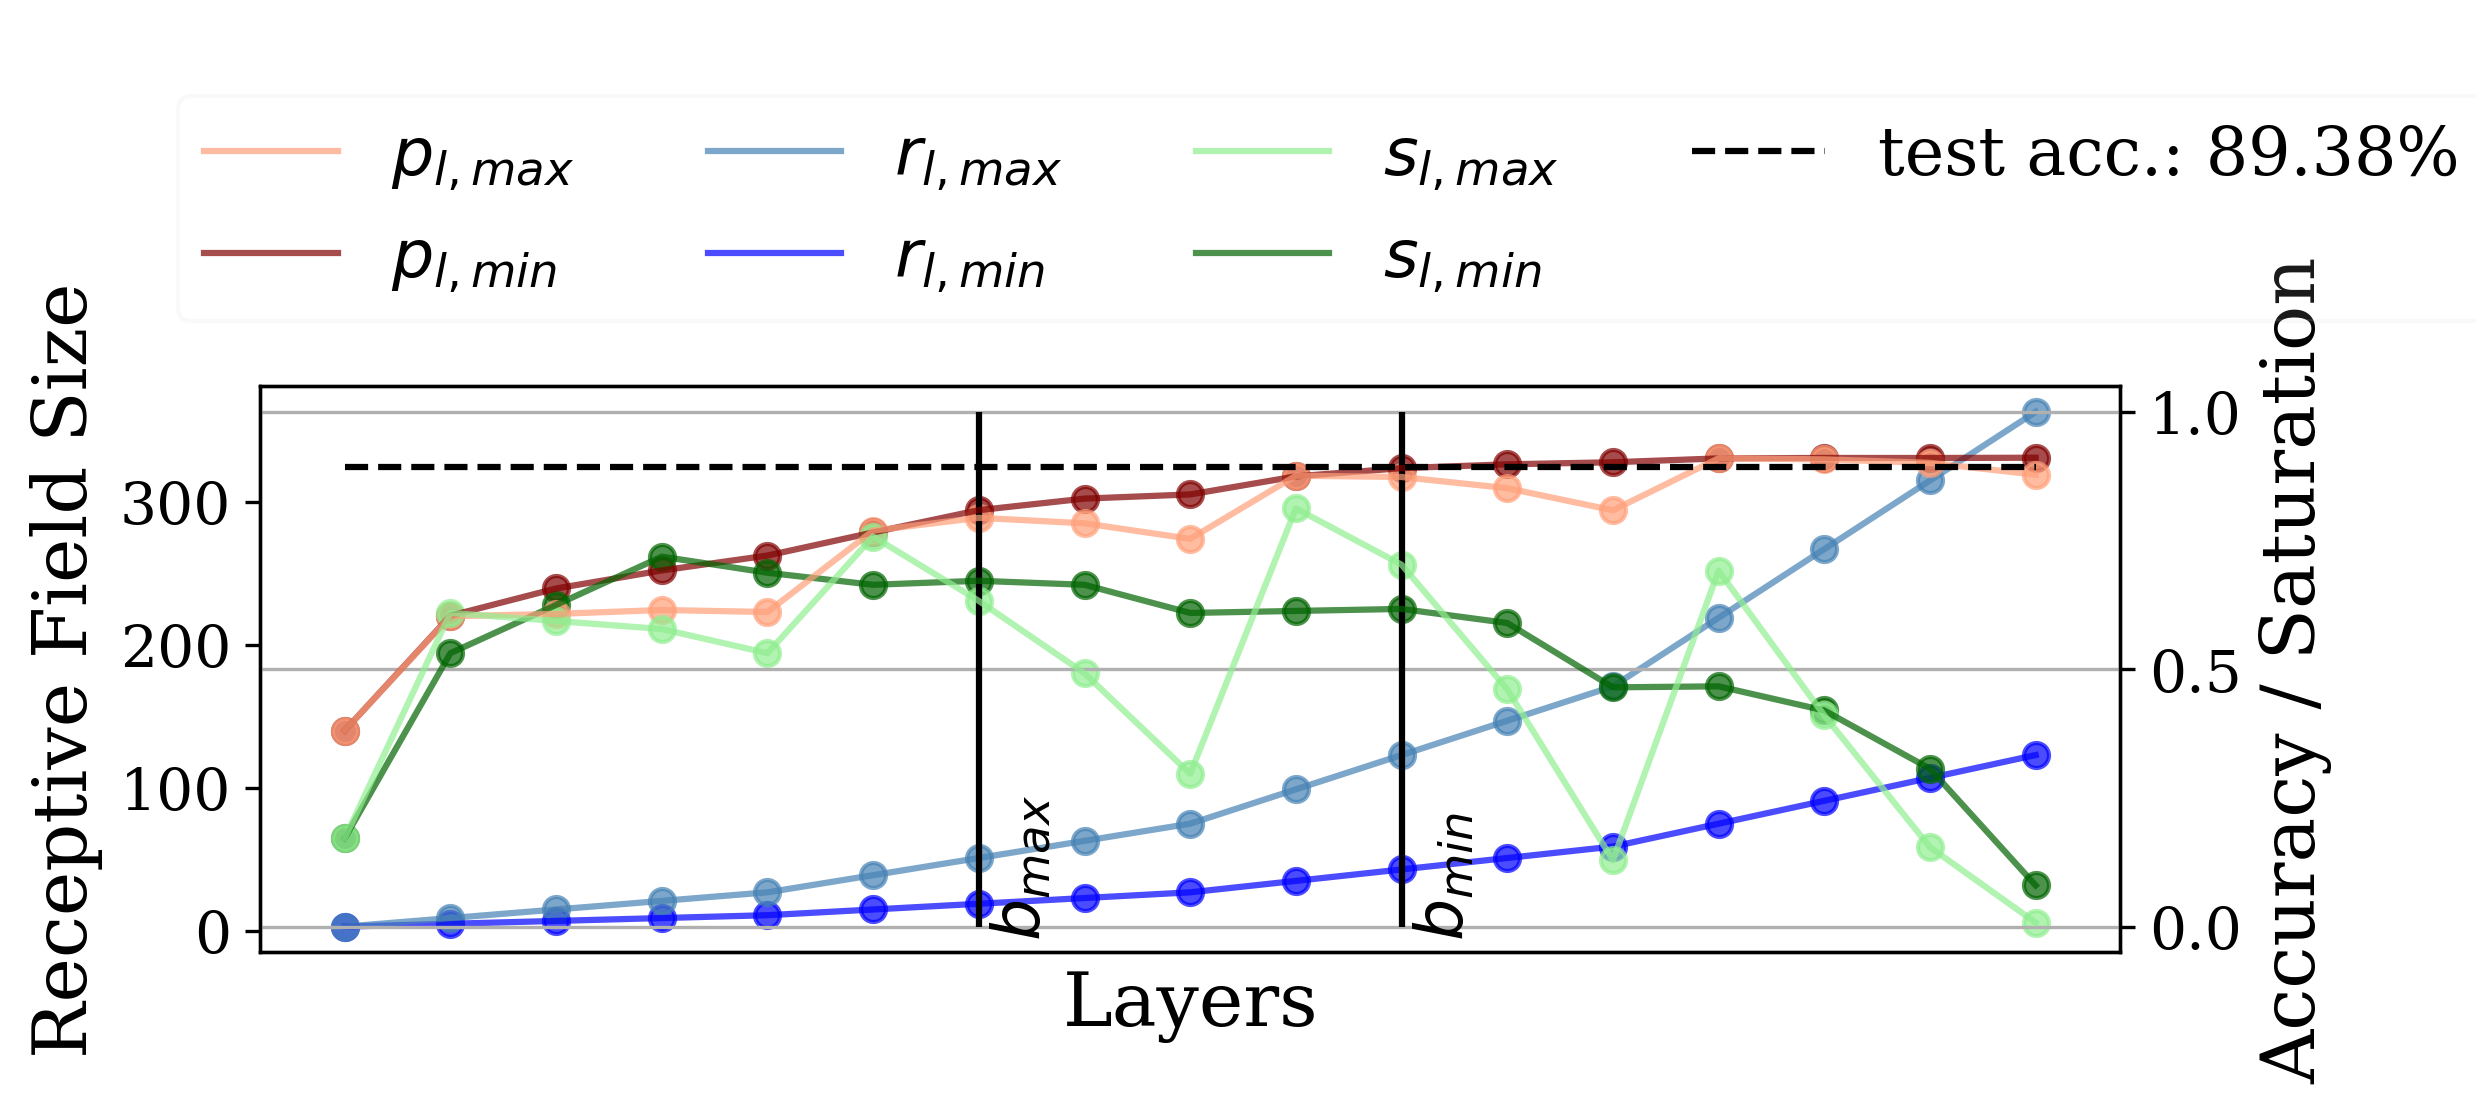

In [57]:
model = "MPNet18_4_4_3_7"
batch_size = 64
epochs = 30
run_id = "DIS"
resolution = 32
dataset = "Cifar10"

sat_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/{model}-{dataset}-r{resolution}-bs{batch_size}-e{epochs}.csv'
probe_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/4x4_probe_performances.csv'
receptive_field_file = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"
receptive_field_file_template = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"

#print(sat_file)
r = plot_multipath(model, sat_file, probe_file, "")
savepath = os.path.join(path,f'{model}_{dataset}_{resolution}.png')
print(model)
plt.savefig(savepath, bbox_inches='tight')

'./logs/MPNet18_1_2_3_7/Cifar10_32/DIS/4x4_probe_performances.csv'
2
'./logs/MPNet18_1_3/Cifar10_32/DIS/receptive_field_MPNet18_1_3_Cifar10_32.csv'
array([ 3.,  5.,  7., 11., 15., 23., 31., 47., 63.])
'./logs/MPNet18_2_7/Cifar10_32/DIS/receptive_field_MPNet18_2_7_Cifar10_32.csv'
array([  3.,   9.,  15.,  21.,  27.,  39.,  51.,  63.,  75.,  99., 123.,
       147., 171., 219., 267., 315., 363.])
{'pathway0': {'conv1': (0.3861, 0.171875, 3.0),
              'stage1-0-pathway0-layers-0-0': (0.6399, 0.53125, 5.0),
              'stage1-1-pathway0-layers-0-0': (0.7139, 0.703125, 7.0),
              'stage2-0-pathway0-layers-0-0': (0.784, 0.6640625, 11.0),
              'stage2-1-pathway0-layers-0-0': (0.8496, 0.6875, 15.0),
              'stage3-0-pathway0-layers-0-0': (0.8905, 0.67578125, 23.0),
              'stage3-1-pathway0-layers-0-0': (0.906, 0.5078125, 31.0),
              'stage4-0-pathway0-layers-0-0': (0.9083, 0.412109375, 47.0),
              'stage4-1-pathway0-layers-0-0': (0.90

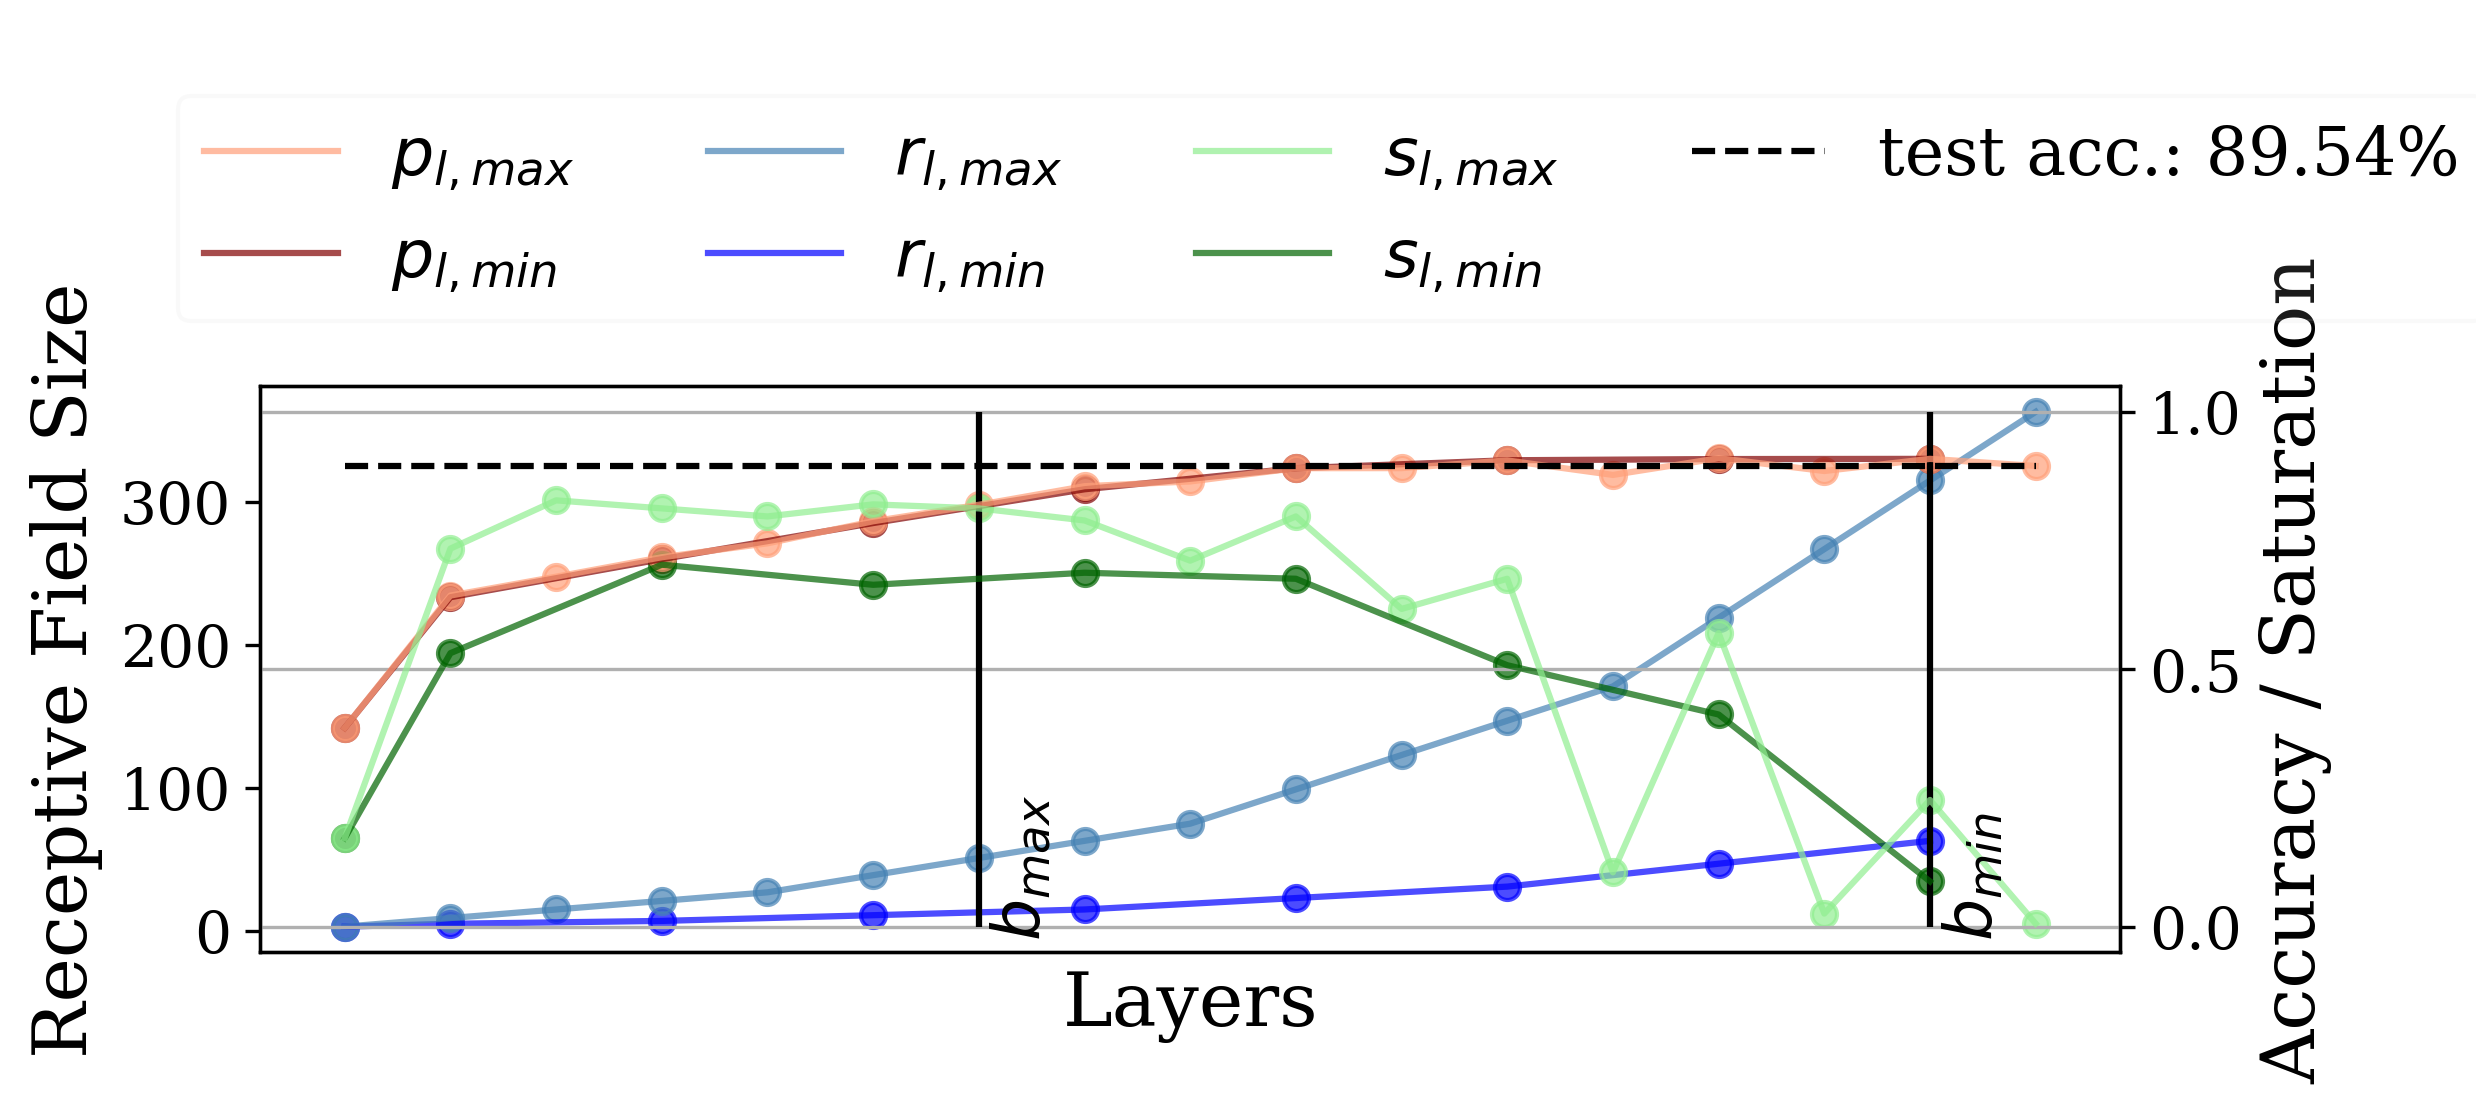

In [58]:
model = "MPNet18_1_2_3_7"
batch_size = 64
epochs = 30
run_id = "DIS"
resolution = 32
dataset = "Cifar10"

sat_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/{model}-{dataset}-r{resolution}-bs{batch_size}-e{epochs}.csv'
probe_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/4x4_probe_performances.csv'
receptive_field_file = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"
receptive_field_file_template = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"

#print(sat_file)
r = plot_multipath(model, sat_file, probe_file, "")
savepath = os.path.join(path,f'{model}_{dataset}_{resolution}.png')
print(model)
plt.savefig(savepath, bbox_inches='tight')

'./logs/MPNet18_1_4_3_7/Cifar10_32/DIS/4x4_probe_performances.csv'
2
'./logs/MPNet18_1_3/Cifar10_32/DIS/receptive_field_MPNet18_1_3_Cifar10_32.csv'
array([ 3.,  5.,  7., 11., 15., 23., 31., 47., 63.])
'./logs/MPNet18_4_7/Cifar10_32/DIS/receptive_field_MPNet18_4_7_Cifar10_32.csv'
array([  3.,   9.,  15.,  21.,  27.,  39.,  51.,  63.,  75.,  99., 123.,
       147., 171., 219., 267., 315., 363.])
{'pathway0': {'conv1': (0.3817, 0.171875, 3.0),
              'stage1-0-pathway0-layers-0-0': (0.635, 0.5625, 5.0),
              'stage2-0-pathway0-layers-0-0': (0.7497, 0.59375, 7.0),
              'stage3-0-pathway0-layers-0-0': (0.7798, 0.64453125, 11.0),
              'stage4-0-pathway0-layers-0-0': (0.8764, 0.419921875, 15.0)},
 'pathway1': {'conv1': (0.3817, 0.171875, 3.0),
              'stage1-0-pathway1-layers-0-0': (0.6433, 0.671875, 9.0),
              'stage1-0-pathway1-layers-1-0': (0.6694, 0.640625, 15.0),
              'stage1-0-pathway1-layers-2-0': (0.6834, 0.5625, 21.0),
      

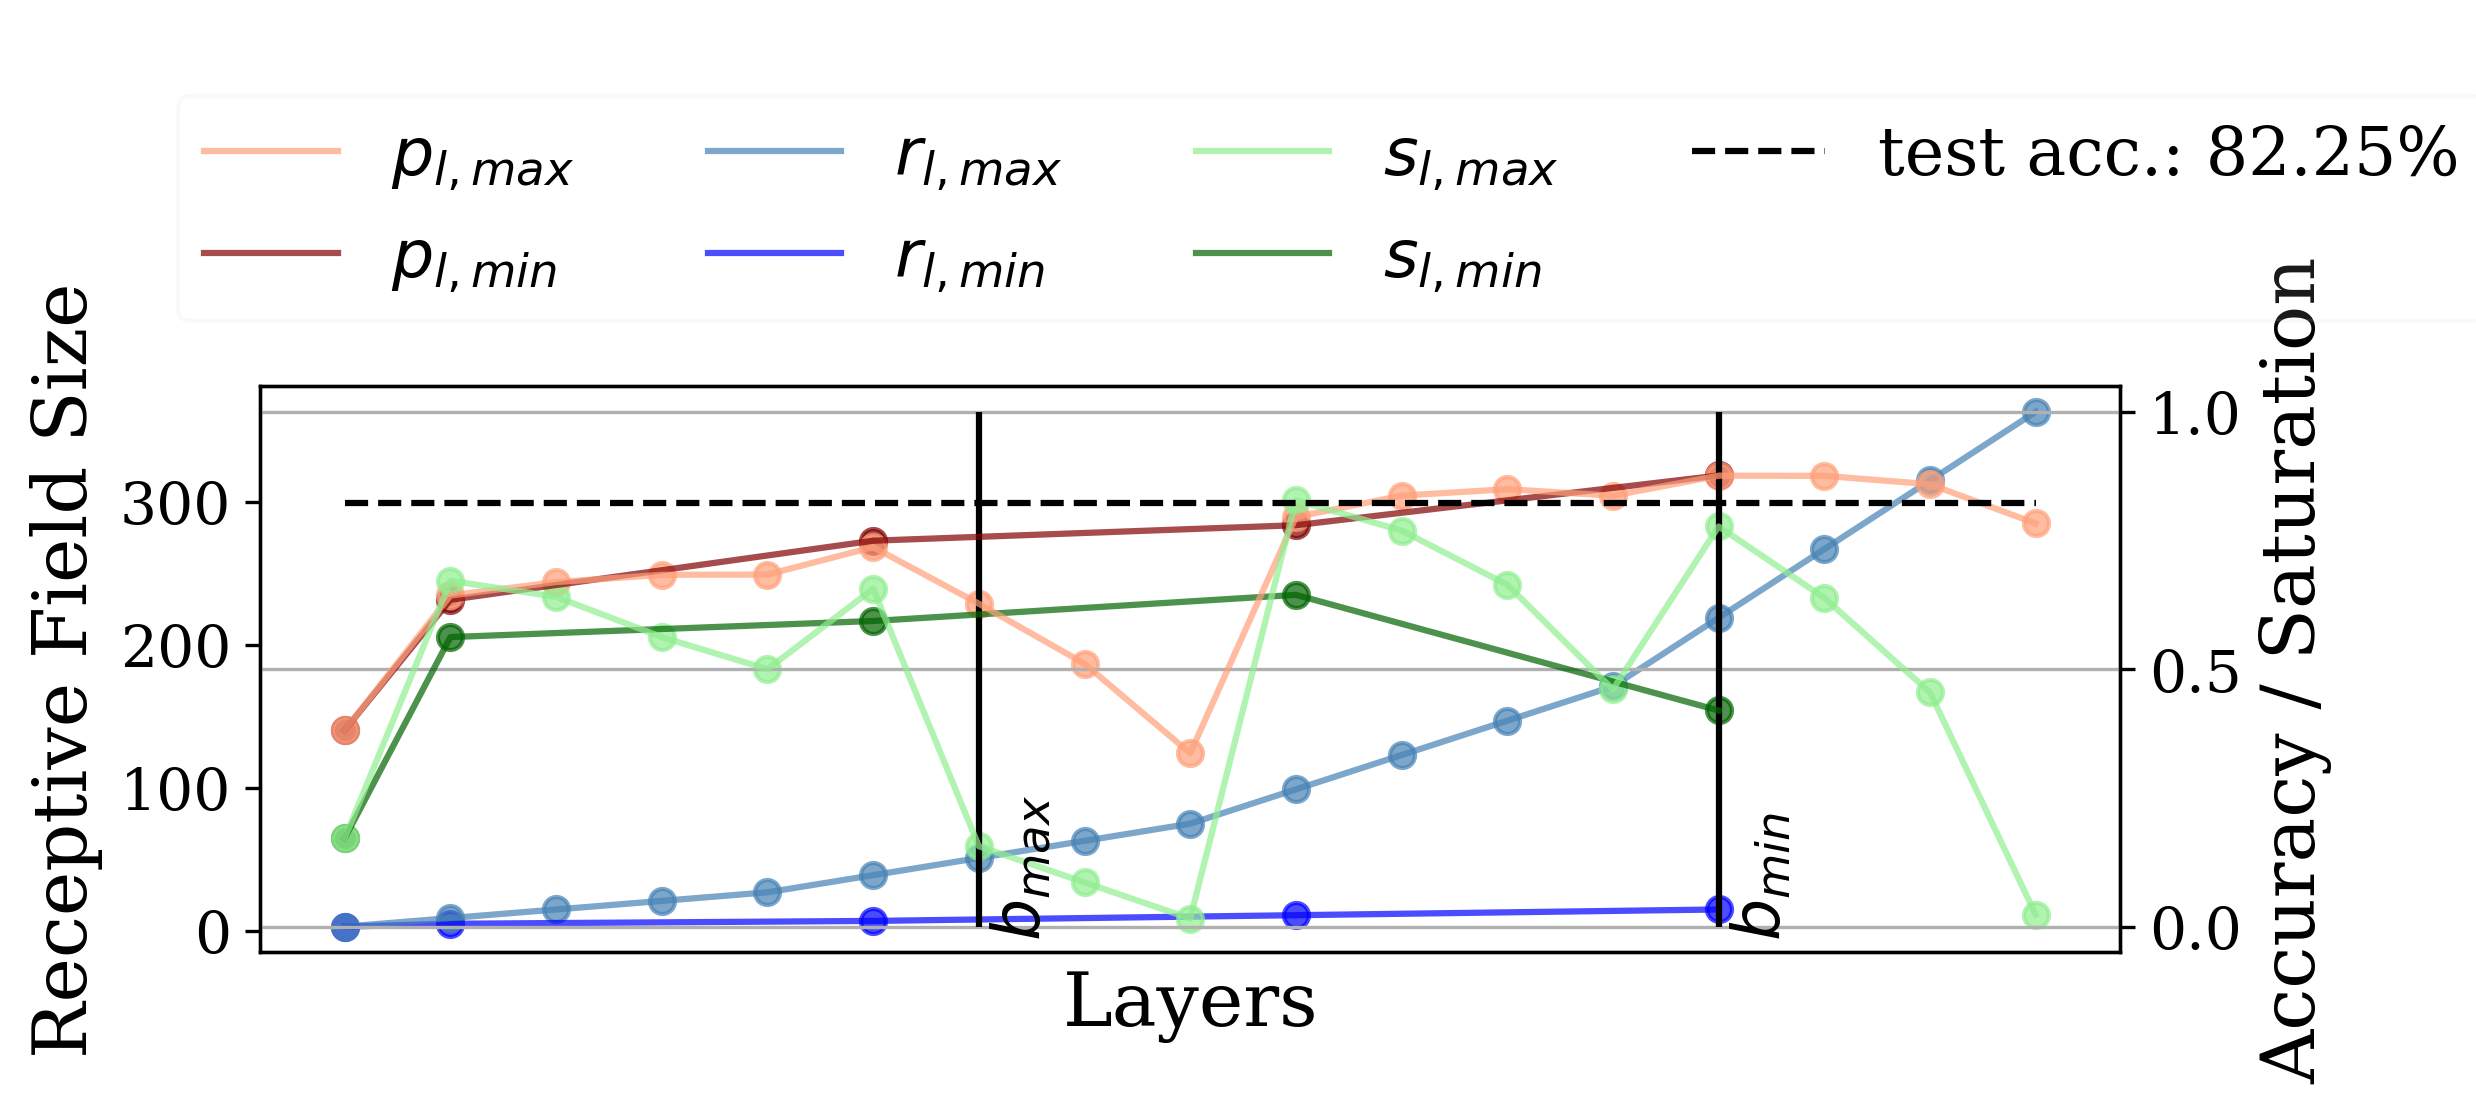

In [59]:
model = "MPNet18_1_4_3_7"
batch_size = 64
epochs = 30
run_id = "DIS"
resolution = 32
dataset = "Cifar10"

sat_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/{model}-{dataset}-r{resolution}-bs{batch_size}-e{epochs}.csv'
probe_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/4x4_probe_performances.csv'
receptive_field_file = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"
receptive_field_file_template = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"

#print(sat_file)
r = plot_multipath(model, sat_file, probe_file, "")
savepath = os.path.join(path,f'{model}_{dataset}_{resolution}.png')
print(model)
plt.savefig(savepath, bbox_inches='tight')

'./logs/MPNet18_1_4_1_7/Cifar10_32/DIS/4x4_probe_performances.csv'
2
'./logs/MPNet18_1_1/Cifar10_32/DIS/receptive_field_MPNet18_1_1_Cifar10_32.csv'
array([3., 3., 3., 3., 3., 3., 3., 3., 3.])
'./logs/MPNet18_4_7/Cifar10_32/DIS/receptive_field_MPNet18_4_7_Cifar10_32.csv'
array([  3.,   9.,  15.,  21.,  27.,  39.,  51.,  63.,  75.,  99., 123.,
       147., 171., 219., 267., 315., 363.])
{'pathway0': {'conv1': (0.3822, 0.171875, 3.0),
              'stage1-0-pathway0-layers-0-0': (0.6402, 0.546875, 3.0),
              'stage2-0-pathway0-layers-0-0': (0.7971, 0.5859375, 3.0),
              'stage3-0-pathway0-layers-0-0': (0.8131, 0.63671875, 3.0),
              'stage4-0-pathway0-layers-0-0': (0.891, 0.419921875, 3.0)},
 'pathway1': {'conv1': (0.3822, 0.171875, 3.0),
              'stage1-0-pathway1-layers-0-0': (0.6494, 0.71875, 9.0),
              'stage1-0-pathway1-layers-1-0': (0.6913, 0.796875, 15.0),
              'stage1-0-pathway1-layers-2-0': (0.7378, 0.765625, 21.0),
            

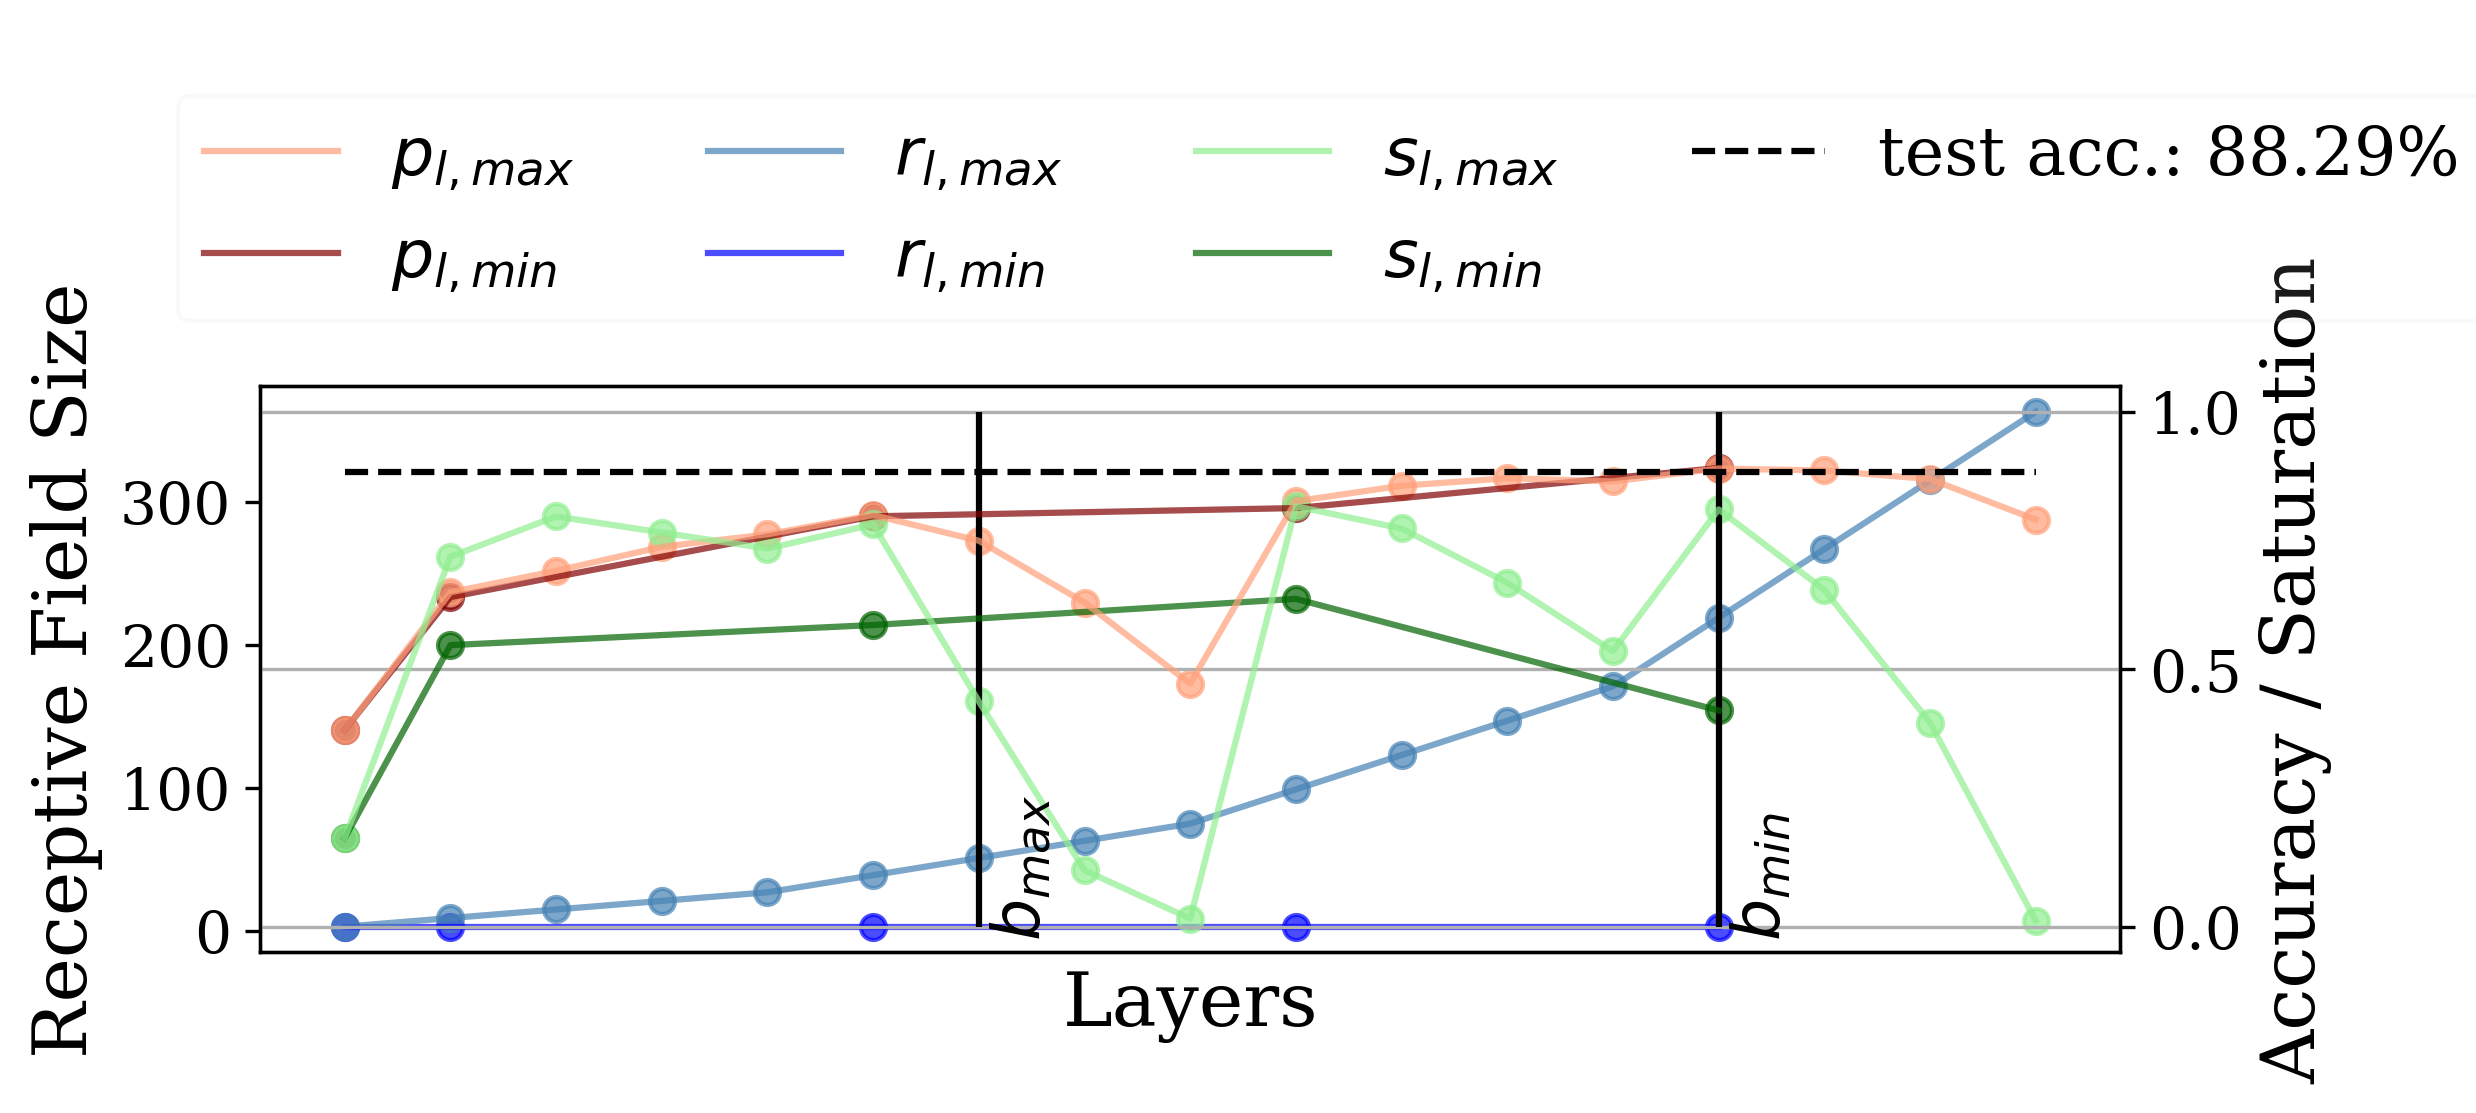

In [60]:
model = "MPNet18_1_4_1_7"
batch_size = 64
epochs = 30
run_id = "DIS"
resolution = 32
dataset = "Cifar10"

sat_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/{model}-{dataset}-r{resolution}-bs{batch_size}-e{epochs}.csv'
probe_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/4x4_probe_performances.csv'
receptive_field_file = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"
receptive_field_file_template = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"

#print(sat_file)
r = plot_multipath(model, sat_file, probe_file, "")
savepath = os.path.join(path,f'{model}_{dataset}_{resolution}.png')
print(model)
plt.savefig(savepath, bbox_inches='tight')

'./logs/MPNet36_1_2_3_7/Cifar10_32/DIS/4x4_probe_performances.csv'
2
'./logs/MPNet36_1_3/Cifar10_32/DIS/receptive_field_MPNet36_1_3_Cifar10_32.csv'
array([  3.,   5.,   7.,   9.,  11.,  15.,  19.,  23.,  27.,  35.,  43.,
        51.,  59.,  75.,  91., 107., 123.])
'./logs/MPNet36_2_7/Cifar10_32/DIS/receptive_field_MPNet36_2_7_Cifar10_32.csv'
array([  3.,   9.,  15.,  21.,  27.,  33.,  39.,  45.,  51.,  63.,  75.,
        87.,  99., 111., 123., 135., 147., 171., 195., 219., 243., 267.,
       291., 315., 339., 387., 435., 483., 531., 579., 627., 675., 723.])
{'pathway0': {'conv1': (0.381, 0.109375, 3.0),
              'stage1-0-pathway0-layers-0-0': (0.6403, 0.46875, 5.0),
              'stage1-1-pathway0-layers-0-0': (0.6988, 0.609375, 7.0),
              'stage1-2-pathway0-layers-0-0': (0.7475, 0.546875, 9.0),
              'stage1-3-pathway0-layers-0-0': (0.7763, 0.515625, 11.0),
              'stage2-0-pathway0-layers-0-0': (0.803, 0.5546875, 15.0),
              'stage2-1-pathway0-

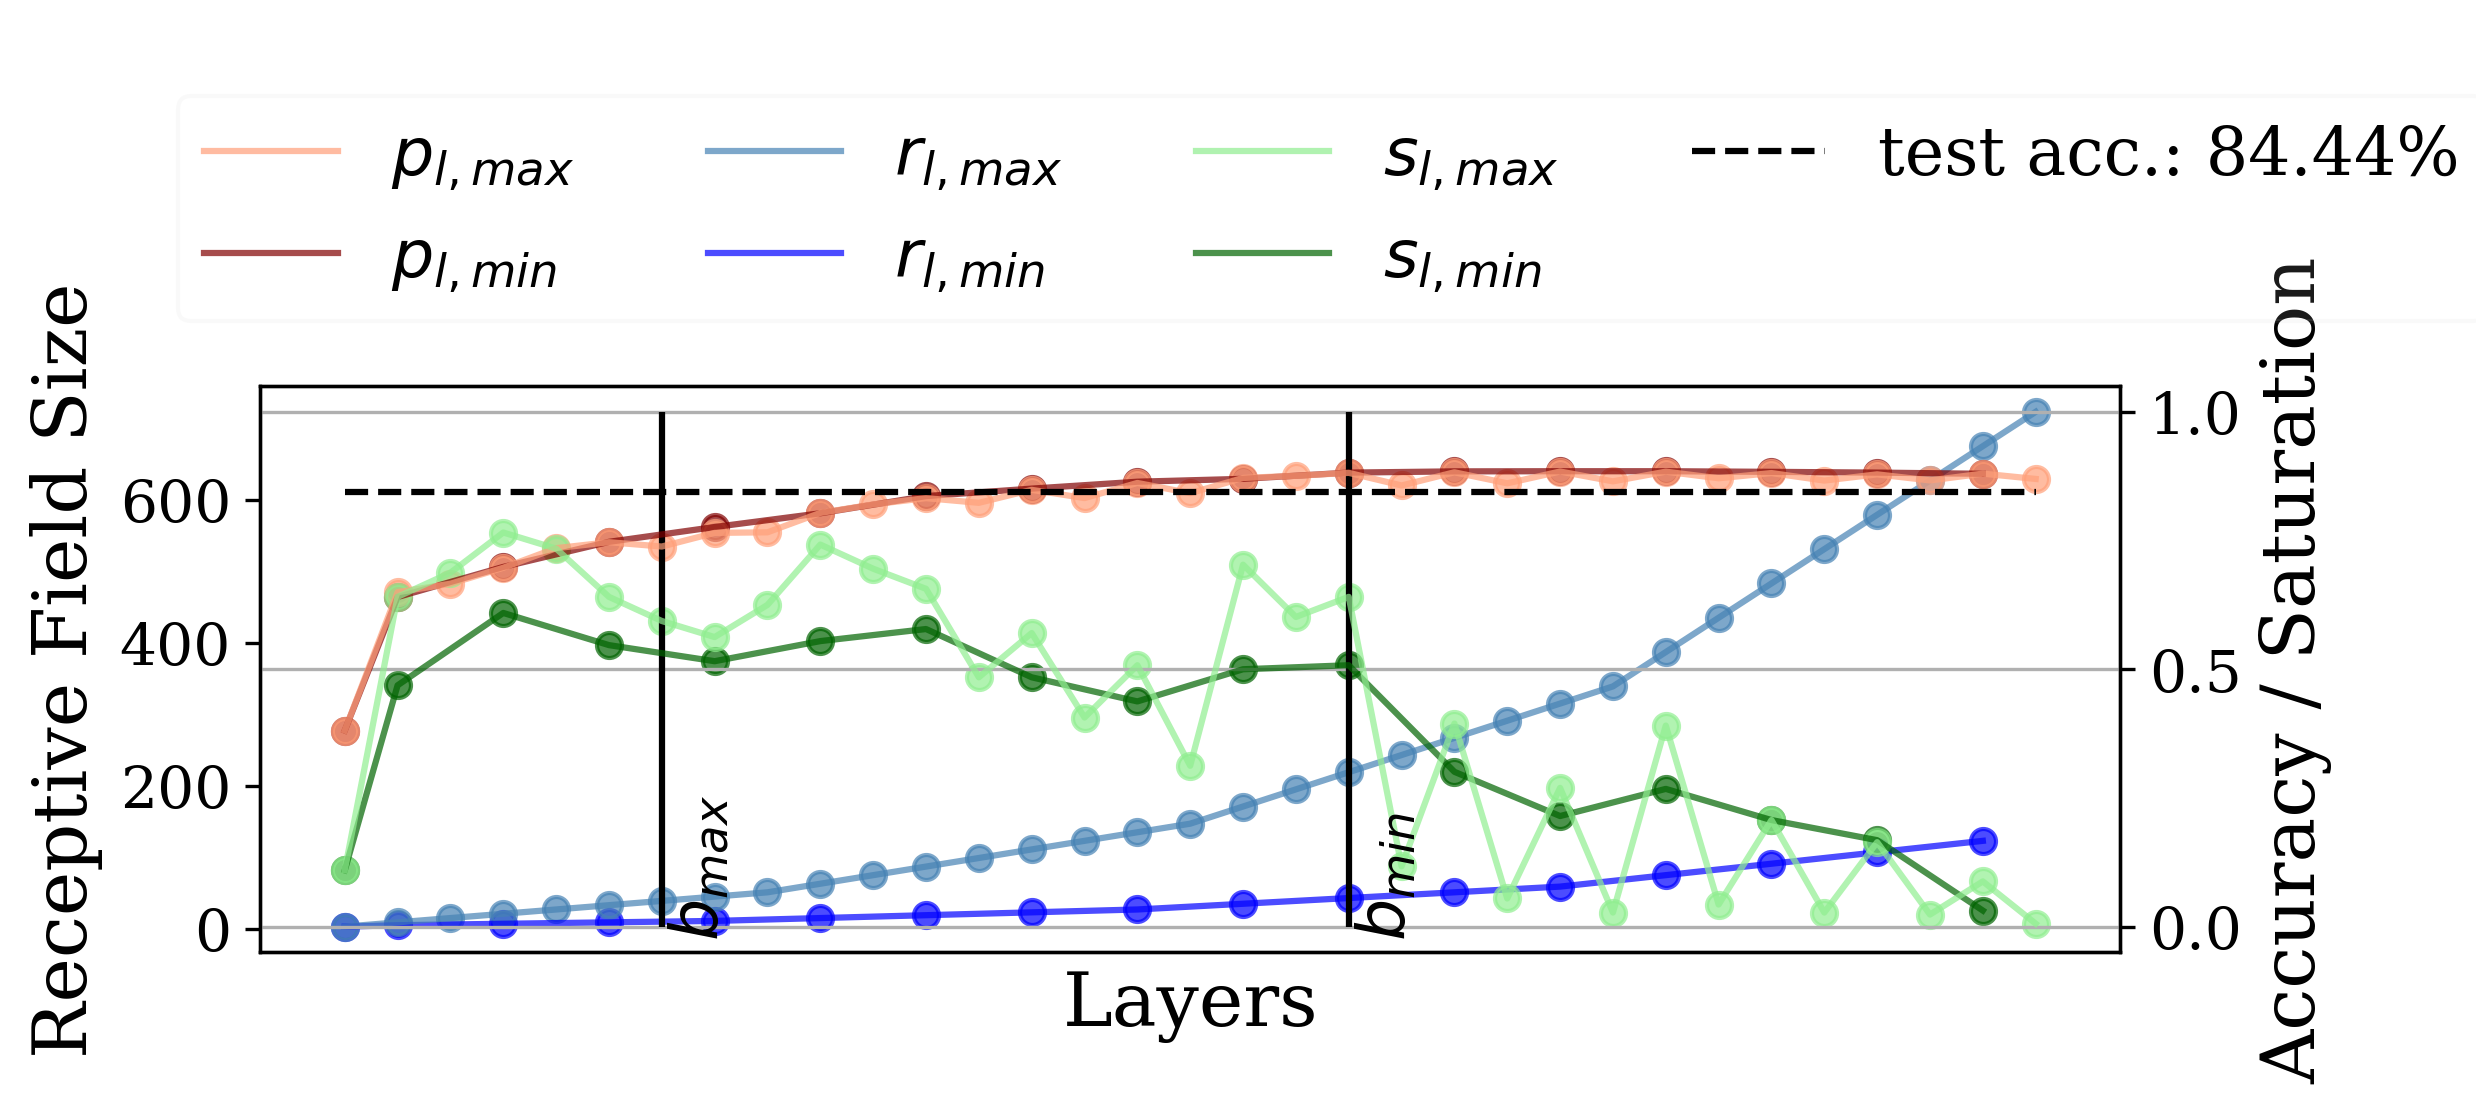

In [61]:
model = "MPNet36_1_2_3_7"
batch_size = 64
epochs = 30
run_id = "DIS"
resolution = 32
dataset = "Cifar10"

sat_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/{model}-{dataset}-r{resolution}-bs{batch_size}-e{epochs}.csv'
probe_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/4x4_probe_performances.csv'
receptive_field_file = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"
receptive_field_file_template = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"

#print(sat_file)
r = plot_multipath(model, sat_file, probe_file, "")
savepath = os.path.join(path,f'{model}_{dataset}_{resolution}.png')
print(model)
plt.savefig(savepath, bbox_inches='tight')

'./logs/MPNet36_1_4_3_7/Cifar10_32/DIS/4x4_probe_performances.csv'
2
'./logs/MPNet36_1_3/Cifar10_32/DIS/receptive_field_MPNet36_1_3_Cifar10_32.csv'
array([  3.,   5.,   7.,   9.,  11.,  15.,  19.,  23.,  27.,  35.,  43.,
        51.,  59.,  75.,  91., 107., 123.])
'./logs/MPNet36_4_7/Cifar10_32/DIS/receptive_field_MPNet36_4_7_Cifar10_32.csv'
array([  3.,   9.,  15.,  21.,  27.,  33.,  39.,  45.,  51.,  63.,  75.,
        87.,  99., 111., 123., 135., 147., 171., 195., 219., 243., 267.,
       291., 315., 339., 387., 435., 483., 531., 579., 627., 675., 723.])
{'pathway0': {'conv1': (0.3823, 0.140625, 3.0),
              'stage1-0-pathway0-layers-0-0': (0.5788, 0.46875, 5.0),
              'stage1-1-pathway0-layers-0-0': (0.6637, 0.59375, 7.0),
              'stage2-0-pathway0-layers-0-0': (0.7153, 0.6328125, 9.0),
              'stage2-1-pathway0-layers-0-0': (0.7736, 0.65625, 11.0),
              'stage3-0-pathway0-layers-0-0': (0.823, 0.69140625, 15.0),
              'stage3-1-pathway0

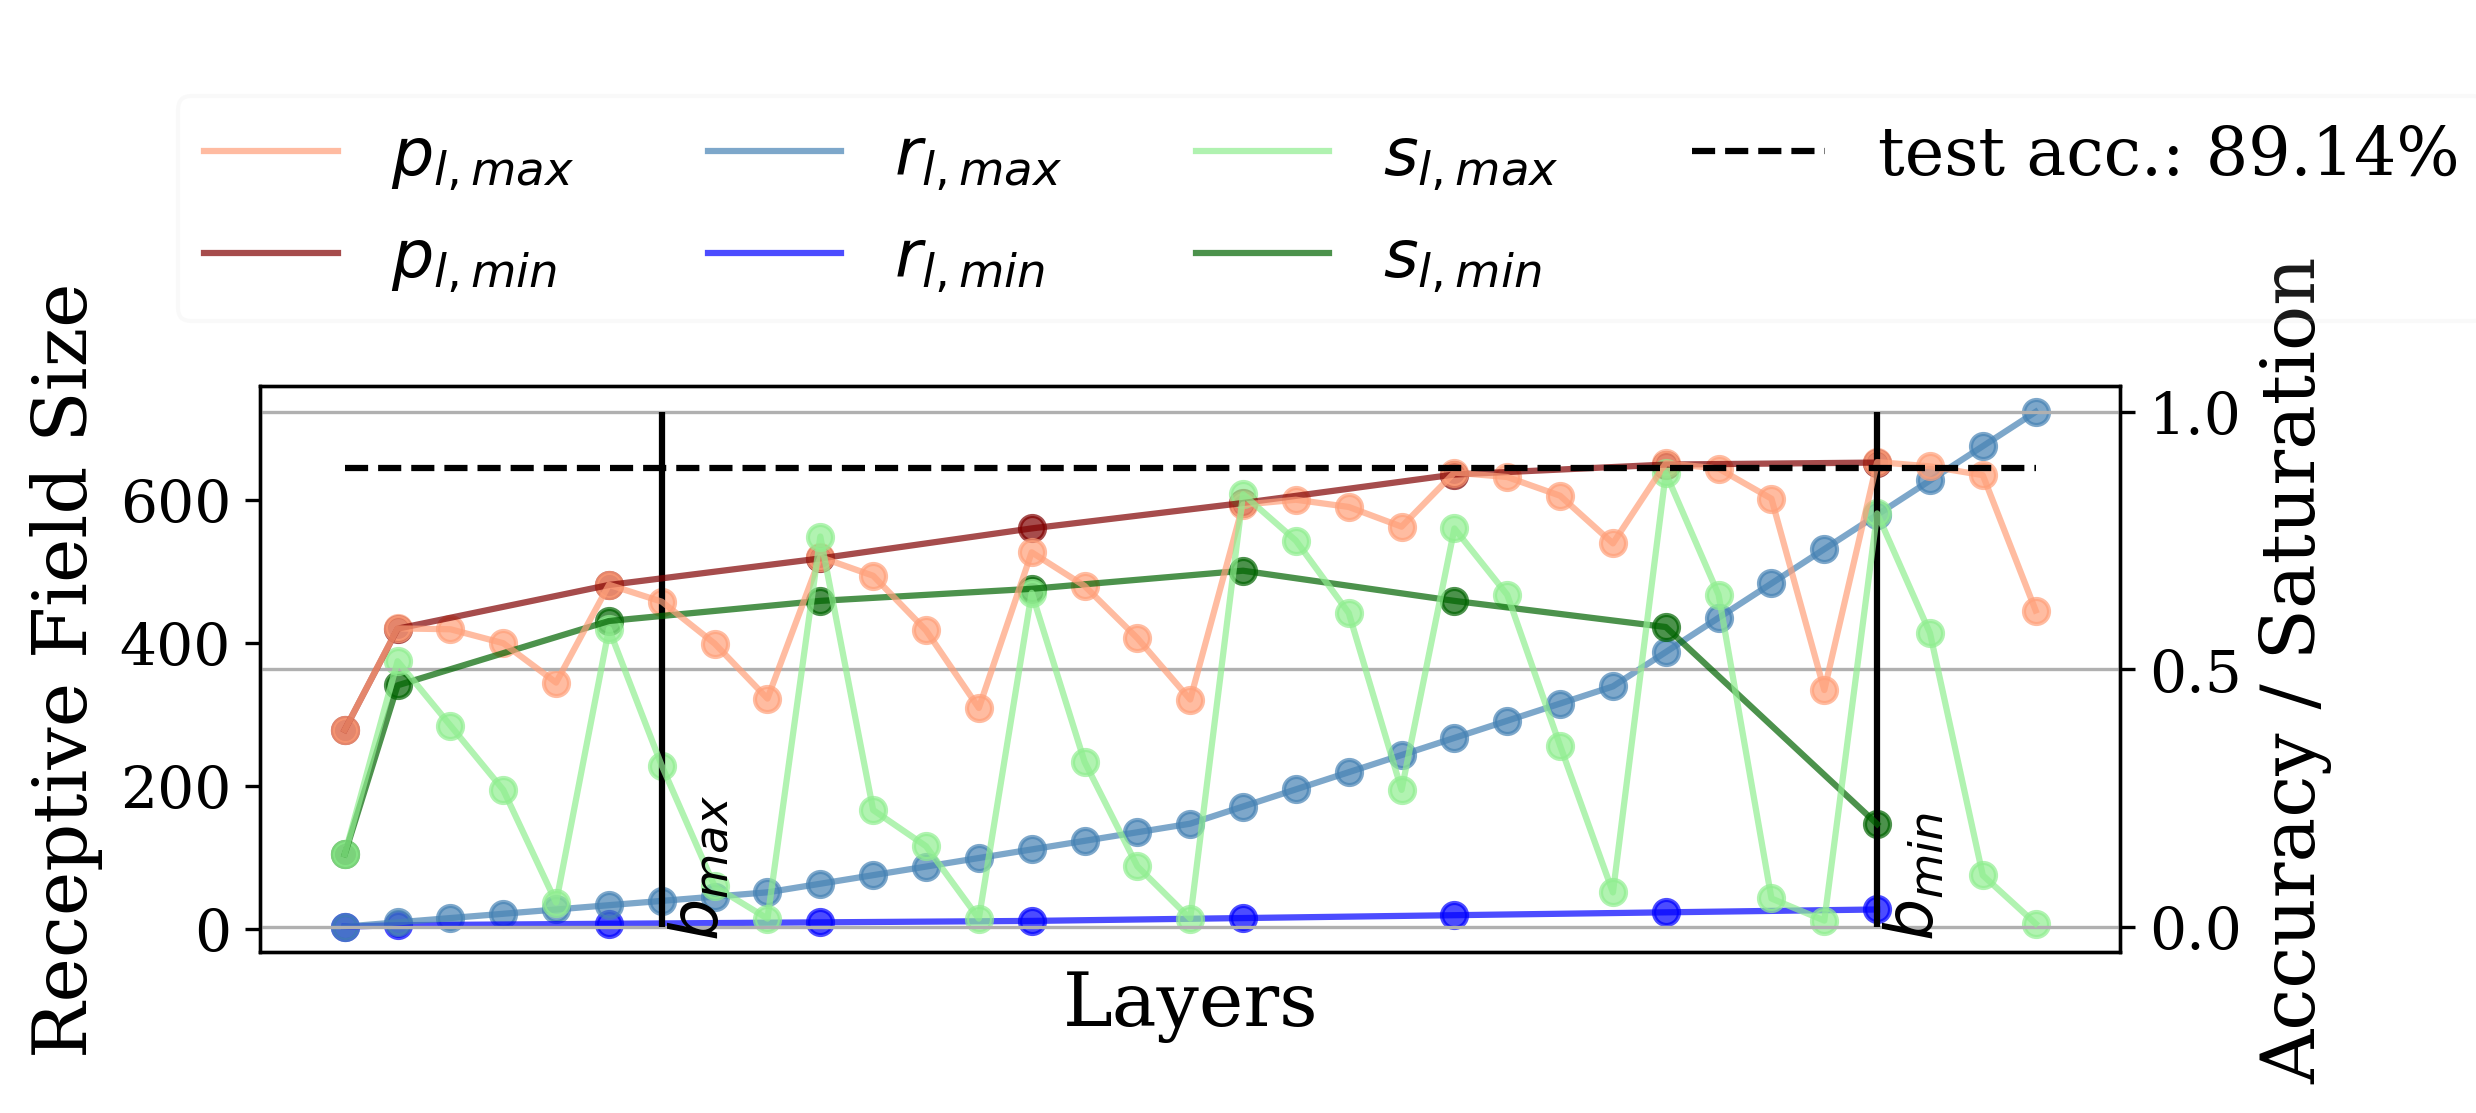

In [62]:
model = "MPNet36_1_4_3_7"
batch_size = 64
epochs = 30
run_id = "DIS"
resolution = 32
dataset = "Cifar10"

sat_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/{model}-{dataset}-r{resolution}-bs{batch_size}-e{epochs}.csv'
probe_file = f'./logs/{model}/{dataset}_{resolution}/{run_id}/4x4_probe_performances.csv'
receptive_field_file = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"
receptive_field_file_template = f"./logs/{model}/{dataset}_{resolution}/{run_id}/receptive_field_{model}_{dataset}_{resolution}.csv"

#print(sat_file)
r = plot_multipath(model, sat_file, probe_file, "")
savepath = os.path.join(path,f'{model}_{dataset}_{resolution}.png')
print(model)
plt.savefig(savepath, bbox_inches='tight')

## Conclusion
Let $r_{max}$ be the path of the largest receptive field expansion
Let $r_{min}$ be the path of the smallest receptive field expansion

if the border layer of $l$ for $r_l \in r_{min}$ is the last layer or is much smaller than than the input image size, the secondary pathway will behave similar to residual connection 